In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from IPython.display import Image
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [2]:
data = pd.read_csv('https://sololearn.com/uploads/files/titanic.csv')

# Logistic regression

For continuous/categorical -> categorical

Model: sigmoid(wx + b) = probability that y = 1. Apply maximum likelihood to this.

### Regularisation: 

punishes non-zero coefficients to reduce overfitting. 

L1: punishment $\alpha$ coefficient

L2: punishment $\alpha$ coefficient ^ 2  (most used)

In [3]:
df = data.copy()
df['Sex'] = df['Sex'] == 'male'
feature_names = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses', 'Parents/Children', 'Fare']
X = df[feature_names]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model evaluation

In [4]:
accuracy = sum(y_test == y_pred) / len(y_test)
print(f'Accuracy = {accuracy}')

Accuracy = 0.8243243243243243


In [5]:
true_positive = sum((y_test == 1) & (y_pred == 1)) / len(y_test)
false_positive = sum((y_test == 0) & (y_pred == 1)) / len(y_test)
true_negative = sum((y_test == 0) & (y_pred == 0)) / len(y_test)
false_negative = sum((y_test == 1) & (y_pred == 0)) / len(y_test)
confusion_matix = pd.DataFrame(
    {
        'Actual positive': [true_positive, false_negative], 
        'Actual negative': [false_positive, true_negative],
    },
        index=['Predicted positive', 'Predicated negative']
)
confusion_matix

,Actual positive,Actual negative
Predicted positive,0.265766,0.063063
Predicated negative,0.112613,0.558559


In [6]:
# precision = the pct of the models positive predictions that were correct
precision = true_positive / (true_positive + false_positive)
print(f'Precision = {precision}')

# recall = the pct of positive cases that the model predicts correctly. AKA sensitivity
recall = true_positive / (true_positive + false_negative)
sensitivity = recall
print(f'Recall = {recall}')

# F1 = the harmonic mean of precision and recall
F1 = 2 * precision * recall / (precision + recall)
print(f'F1 = {F1}')

# Specificity = true negative rate
specificity = true_negative

Precision = 0.8082191780821919
Recall = 0.7023809523809523
F1 = 0.7515923566878981


### ROC curve

We want specificity and sensitivity high, but to increase one we typically sacrifice the other 

Text(0, 0.5, 'sensitivity')

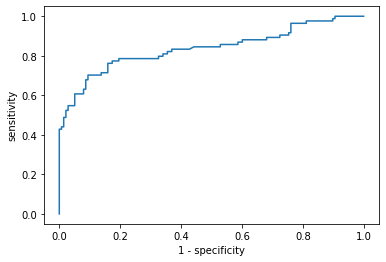

In [7]:
y_predict_proba = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')

In [8]:
area_under_curve = roc_auc_score(y_test, y_predict_proba[:, 1])
area_under_curve

0.83756038647343

### k-fold cross validation

Make maximum use of all the data. Split the dataset into test and training 5 times, such that each datapoint is in exactly one test set. Evaluate the model based on the mean scores of each split. Then train on the whole dataset to get the final model.

In [9]:
scores = []
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
print(scores)
print(f'Mean accuracy = {np.mean(scores)}')

[0.8370786516853933, 0.7921348314606742, 0.8192090395480226, 0.7740112994350282, 0.7909604519774012]
Mean accuracy = 0.802678854821304


# Decision tree

Make splits to maximise the information gain. First we need a measure of purity, of which there are two: entropy and gini impurity. Both give similar results in most cases.

$gini = 2 * p * (1-p)$

Then information gain is defined:

$I = H(S) - \frac{|A|}{|S|} H(A) - \frac{|B|}{|S|} H(B)$

Where $H$ is gini, $S$ is the original dataset, and $A$ and $B$ are the two split datasets

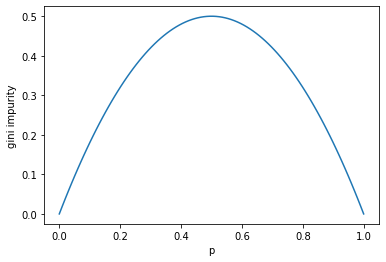

In [59]:
p = np.linspace(0, 1, 100)
gini = 2 * p * (1 - p)
plt.plot(p, gini)
plt.xlabel('p')
plt.ylabel('gini impurity');

In [60]:
model = DecisionTreeClassifier(max_leaf_nodes=5)
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')

Accuracy = 0.8063063063063063
Precision = 0.765625
Recall = 0.6363636363636364
F1 score = 0.6950354609929078


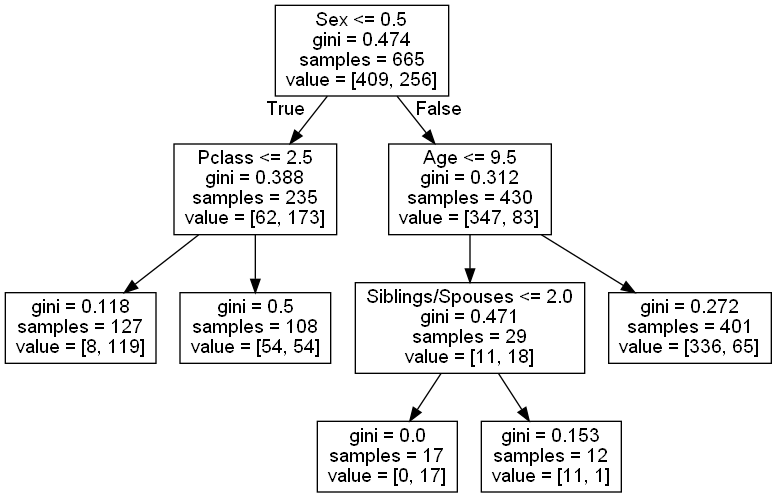

In [30]:
dot_file = export_graphviz(model, feature_names=feature_names)
graph = graphviz.Source(dot_file)
Image(graph.render(filename='tree', format='png', cleanup=True))

### Hyperparameter tuning

We can grid search pre-pruning parameters

In [61]:
param_grid = {
    'max_depth': [5, 15, 25],
    'min_samples_leaf': [1, 3],
    'max_leaf_nodes': [10, 20, 35, 50]
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)     # uses k-fold cross validation
grid_search.fit(X, y)
print(f'Best params: {grid_search.best_params_}')
print(f'Best F1 score: {grid_search.best_score_}')

Best params: {'max_depth': 25, 'max_leaf_nodes': 35, 'min_samples_leaf': 1}
Best F1 score: 0.7733926442202097


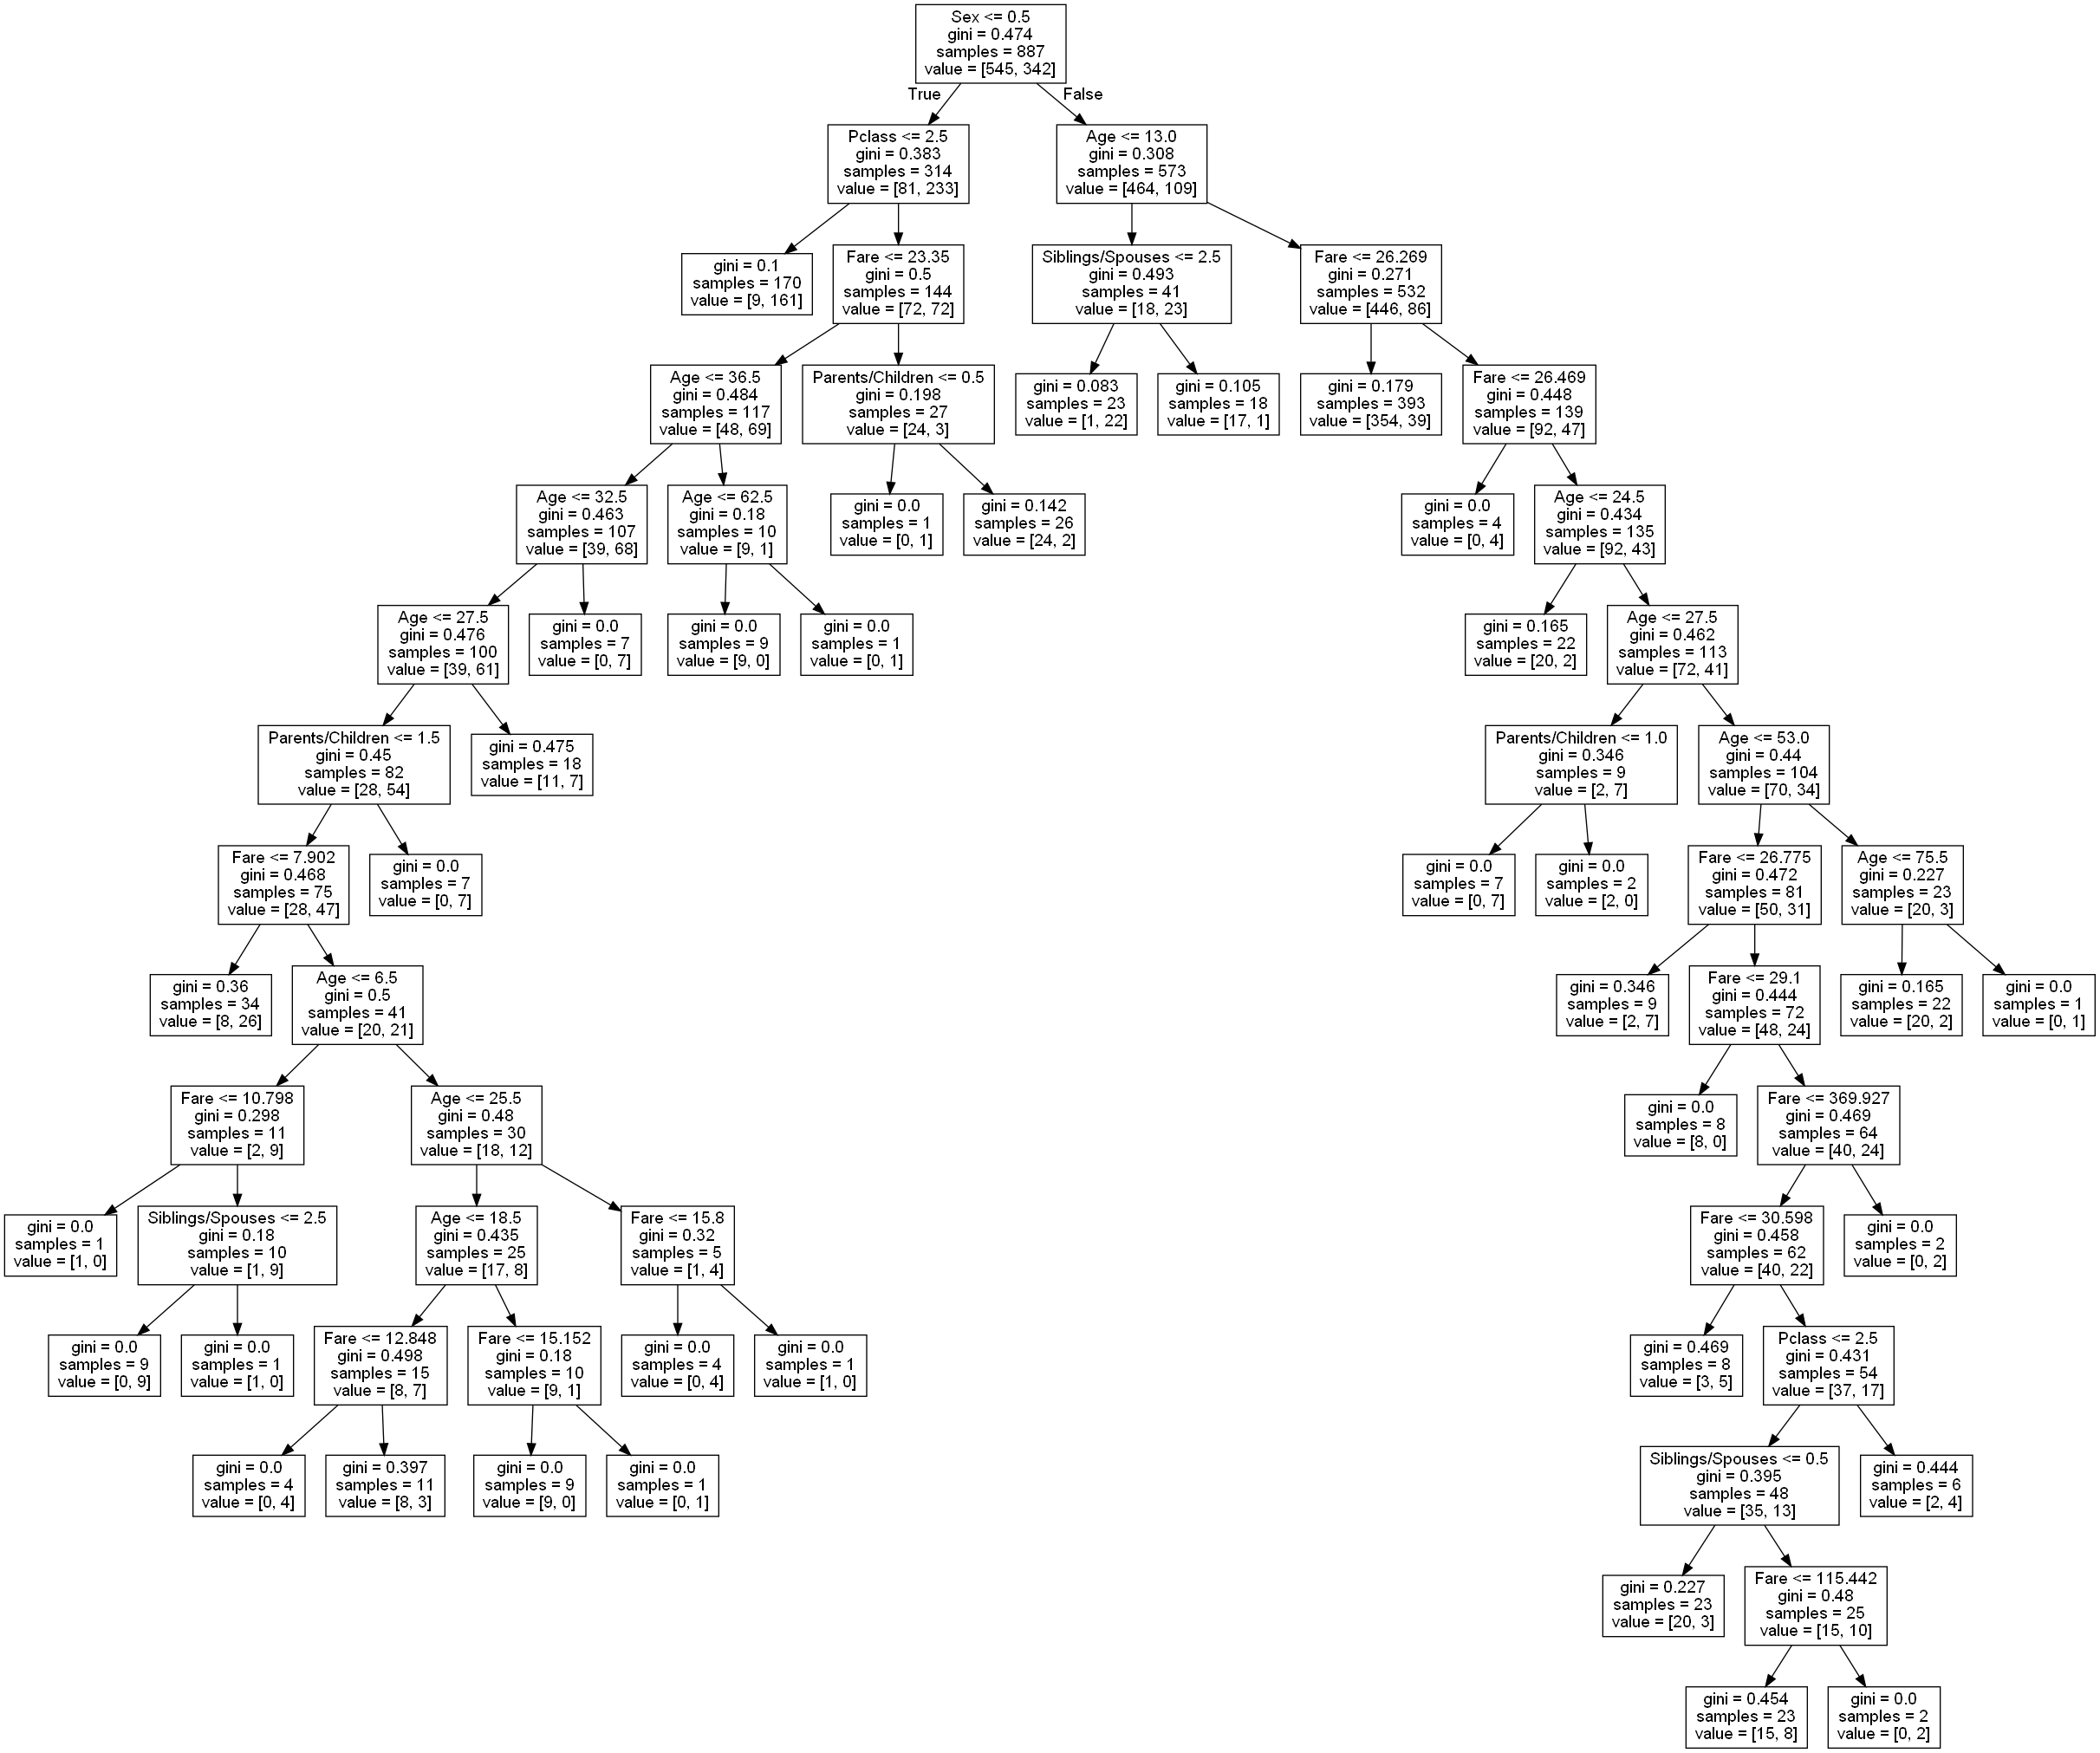

In [62]:
dot_file = export_graphviz(grid_search.best_estimator_, feature_names=feature_names)
graph = graphviz.Source(dot_file)
Image(graph.render(filename='tree', format='png', cleanup=True))

# Random forest